<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BE223C_SPRING_2021/blob/main/VGG_DBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG_DBT
This code will recreate the VGG16 layer model for use in classification of DBT images

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#

from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra


import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
#show model design parameters with torchsummary
import torchsummary
from torchsummary import summary
from torch import FloatTensor
from torch import tensor


from torch.utils.data import DataLoader

### Enable GPU, if present
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')

################################################################################
# Try TPU setup --- version mismatches --- DISABLED 
#
train_on_tpu =0 #enable TPUs
if ((train_on_gpu == 0 ) and train_on_tpu == 1):
    !pip3 install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
    # imports the torch_xla package
    import torch_xla
    import torch_xla.core.xla_model as xm
    dev = xm.xla_device()
    print('!!!! USING TPU!!!!')
################################################################################
#
# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/My Drive/DBT_DATA/IMG_ARRAYS'
patch_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 
model_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/MODEL_SAVE'
tensorboard_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/TENSORBOARD_SUMMARIES'



     |████████████████████████████████| 1.9MB 13.8MB/s 
     |████████████████████████████████| 133kB 13.8MB/s 
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-2d1bb1a2-656b-1ed7-800d-dfc1397cbee1)
Thu Jun 10 23:41:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |   

#GET LIST OF PRE-GENERATED CATEGORIES AVAILABLE
These files were pre-built patches generated from the TRAINING DATA

In [2]:
################################################################################
# GET FULL LIST OF FILES IN IMAGE ARRAY DIRECTORY
################################################################################
use_patch_files = 1
if (use_patch_files == 0):
    raw_files = os.listdir(data_dir)
    print('found #files: ',len(raw_files))
else: #patches broken up into directories
    category_folders = os.listdir(patch_dir)
    #raw_files = os.listdir(data_dir)
    #print('found #files: ',len(raw_files))    

if (0):
    #create fake patches for now
    patch_dict = {}
    for counter,filename in enumerate(raw_files):
        #load full array
        full_filename = os.path.join(data_dir,filename)
        img_data = pickle.load( open( full_filename, "rb" ) )
        patch_data = img_data[0:3,:,:]
        patch_dict[counter]= patch_data
        print(full_filename,np.shape(patch_data))

        if (counter > 0):
            break
        
### SKIP ACTIONABLE FOLDER
### Remove actionable folder item from list, since we're no longer using that data
category_folders.remove('ACTIONABLE')

#GENERATE LIST OF PATCH FILES IN CATEGORY FOLDERS

In [3]:
for ii in category_folders:
    print(ii)
    flist = os.listdir(os.path.join(patch_dir,ii))

temp = flist[0].split(sep='_')
print(temp[3])

NORMAL
BENIGN
CANCER
Cancer


#BUILD INDIVIDUAL FILES LIST

In [4]:
#generate full file list for use in indexing the dataloader
#this replaces the older loader, which was only inputting Normal
full_file_list = [] #store the full filename of every file
full_category_name = []
for category_folder in category_folders:
            print('------------- ',category_folder)
            file_list = os.listdir(os.path.join(patch_dir,category_folder))
            cat_count = 0
            for file_name in file_list:
                cat_count = cat_count + 1
                full_category_name.append(category_folder)
                full_file_list.append(file_name)
                print(os.path.join(category_folder,file_name))
            print('------->category & count ',category_folder, cat_count)
full_file_count = len(full_file_list)
print(len(full_file_list))
full_file_list[0]


Streaming output truncated to the last 5000 lines.
NORMAL/DBT-P03081_DBT-S05220_lcc_Normal_s42_cx347_cy1319_244_244.pickle
NORMAL/DBT-P03081_DBT-S05220_rmlo_Normal_s26_cx1496_cy1032_244_244.pickle
NORMAL/DBT-P03081_DBT-S05220_rcc_Normal_s24_cx1532_cy1240_244_244.pickle
NORMAL/DBT-P03079_DBT-S00277_lmlo_Normal_s70_cx507_cy1204_244_244.pickle
NORMAL/DBT-P03079_DBT-S00277_rcc_Normal_s39_cx1460_cy1158_244_244.pickle
NORMAL/DBT-P03079_DBT-S00277_rmlo_Normal_s47_cx1386_cy1146_244_244.pickle
NORMAL/DBT-P03079_DBT-S00277_lcc_Normal_s11_cx478_cy1344_244_244.pickle
NORMAL/DBT-P03088_DBT-S02585_rcc_Normal_s41_cx1432_cy1282_244_244.pickle
NORMAL/DBT-P03088_DBT-S02585_lmlo_Normal_s19_cx524_cy1207_244_244.pickle
NORMAL/DBT-P03088_DBT-S02585_lcc_Normal_s3_cx491_cy1372_244_244.pickle
NORMAL/DBT-P03088_DBT-S02585_rmlo_Normal_s16_cx1354_cy1071_244_244.pickle
NORMAL/DBT-P03063_DBT-S01991_lcc_Normal_s42_cx348_cy1286_244_244.pickle
NORMAL/DBT-P03063_DBT-S01991_rcc_Normal_s36_cx1657_cy1245_244_244.pickle
NO

'DBT-P03261_DBT-S05042_rmlo_Normal_s43_cx1582_cy1161_244_244.pickle'

#CLASS FOR OUR CUSTOM DATA FORMAT

In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms  #get normalization functions

class CustomImageDataset(): #Dataset):
    def __init__(self, img_dir,category=[],file_count=1,file_list =[],transform=None, target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        



    def image_normalize(image):
        #replace with the more tensor friendly normalize once tensor shapes confirmed
        image = image/65535.0
        return image


    def __len__(self):
        return self.file_count #len(self.file_list) #99 #len(self.img_labels)

    def __getitem__(self, index):
        
        fname = self.file_list[index]

        #get label and pull category 
        text_tokens = fname.split(sep='_')
        label_class = text_tokens[3] #get the label token in 4th position
        self.category_name =  label_class.upper() 


        full_file_name = os.path.join(self.img_dir,self.category_name,fname)
        image = pickle.load( open( full_file_name, "rb" ) )
        image = image.astype(float) #using patch images
        

        #VERIFY THE IMAGES ARE ALL THE SAME 3x244x244
        shapes = image.shape
        assert (shapes[0] == 3),"Image slice error: {0}".format(fname)
        assert (shapes[1] == 244), print('Image row error: ',fname)
        assert (shapes[2] == 244), print('Image column error: ',fname)
        #if (shapes[0] != 3 and shapes[1] != 244 and shapes[2]!= 244):


        #Normalize the data to 0,1 from 2^16
        image = image/65535.0 #image_normalize(image)



        #test out numeric label
        if (label_class in 'Normal'):
            label = 0
        elif (label_class in 'Actionable'):
            print('!!!!! ACTIONABLE PASSED THROUGH')
            stop()
            label = 1
        elif (label_class in 'Benign'):
            label = 1
        else: # (label_class in 'Cancer'):
            label = 2


        #print(full_file_name)


        #read_image(img_path)
        #label = self.img_labels.iloc[idx, 1]
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        sample = {"image": image, "label": label}
            #sample = file_name
        return sample


        

#GENERATE WEIGHTING FOR UNEVEN CLASSES

In [6]:
#
# Adjust the weighting and sampling of the training data to correct for any
#imbalances. This is used in loss and dataloading
#

#GENERATE THE WEIGHT TENSOR BASED UPON THE LABEL APPLIED
weight_list =[]
for ii in  full_file_list:
        
    for jj in ii:
        if ('Normal' in jj):
            wval = 1
        elif ('Benign' in jj):
            wval = 3
        else:
            wval = 5

        weight_list.append(wval)

    #count = count + len(nfiles)
number_weight_values = len(weight_list)
number_weight_values = torch.tensor(number_weight_values)
print('Number of weight values = ',number_weight_values)

#target_list = full_file_list[torch.randperm(len(full_file_list))]
weight_numbers = torch.tensor([1.6,1.0,1.8], dtype=torch.float32)

#class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
#weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weight_list), int(4))


#sampler = torch.utils.data.WeightedRandomSampler(weights=weight_numbers, 
#                                                 num_samples=number_weight_values, replacement=True)

Number of weight values =  tensor(450602)


#SPLIT DATA INTO SETS AND SETUP DATALOADERS
-- save off the indices for each dataset (for testing with isolated data later)

In [7]:


#
count =0
# Setup the custom dataset
for ii in category_folders:
        nfiles = os.listdir(os.path.join(patch_dir,ii))
        count = count + len(nfiles)
print('Number of patch files found = ',count)

#load up with the pre-sized patch images
training_data = CustomImageDataset(img_dir=patch_dir,
                                   category = full_category_name, 
                                   file_count=full_file_count,
                                   file_list = full_file_list, 
                                   transform=None, 
                                   target_transform=None)

#
# TEST OUT SPLITTING DATASETS INTO TRAIN/TEST
#
train_size = int(0.7 * len(training_data))
val_size = int(0.2 * len(training_data))
test_size = len(training_data) - train_size - val_size
train_subset, val_subset, test_subset = torch.utils.data.random_split(training_data, [train_size, val_size,test_size])


bsize = 50
#training_data = CustomImageDataset( annotations_file='', img_dir=data_dir, file_list=raw_files,transform=None, target_transform=None)
if (train_on_gpu==1):
    print('setting GPU data loads')
    dataloader_training = DataLoader(train_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
    dataloader_validation = DataLoader(val_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
    dataloader_test = DataLoader(test_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
elif ((train_on_tpu == 1) and (train_on_gpu == 0)):
    print('setting TPU data loads')
    dataloader_training = DataLoader(train_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
    dataloader_validation = DataLoader(val_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
    dataloader_test = DataLoader(test_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU

else:
    dataloader_training = DataLoader(train_subset, batch_size=bsize,shuffle=True, num_workers=2)#, sampler=sampler) #only 2 workers for Colab CPU
    dataloader_validation = DataLoader(val_subset, batch_size=bsize,shuffle=True, num_workers=2,drop_last=True)#, sampler=sampler) #only 2 workers for Colab CPU
    dataloader_test = DataLoader(test_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU


############################################
if (0): #disable while testing above, but this works
    bsize = 8
    #training_data = CustomImageDataset( annotations_file='', img_dir=data_dir, file_list=raw_files,transform=None, target_transform=None)
    if (train_on_gpu):
        dataloader = DataLoader(training_data, batch_size=bsize,shuffle=True, num_workers=4) #only 2 workers for Colab CPU
    else:
        dataloader = DataLoader(training_data, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU


Number of patch files found =  6569
setting GPU data loads


#WRITE DATA INDICES TO STORAGE FOR USE LATER

In [8]:
#
# Save file indices for later testing of the final model
#--RUN THIS EVERY TIME YOU USE DATALOADER!!!!! This will give the indices to the
#test files so you can test on them separately

val_index = dataloader_validation.dataset.indices
test_index = dataloader_test.dataset.indices
len(dataloader_validation.dataset.dataset.file_list)
index_file = os.path.join(tensorboard_dir,'data_index.pickle')
pickle.dump([val_index, test_index, file_list],open( index_file, "wb" ),protocol=5 )
print('Saved off Val and Test dataloader indices')

Saved off Val and Test dataloader indices


In [9]:
### DEBUG
#for ii in training_data:
#    print(ii)
#print(full_file_list[401])
#d = next(iter(dataloader_training))
#print(len(d['image']), len(d['label']))
#print(d['label'])
if (0):
    for i, _ in enumerate(dataloader_training, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        pass
        #print(type(data['image']))


        if (i > 0):
            break

if (0):
    #Mixing GPU and CPU model saves doesn't seem to map well yet
    final_file = os.path.join(model_dir,'vgg16_best_accuracy_97_gpu')
    checkpoint = torch.load(final_file, map_location=torch.device('cpu'))
    #model_vgg16 = VGG16(*args, **kwargs)
    #model_vgg16.load_state_dict(torch.load(PATH))
    
    #model_vgg16.load_state_dict(checkpoint)
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']

#DEFINE MODEL LAYERS

In [10]:
from torch import nn

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.flatten = nn.Flatten()
        self.vgg16_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),         
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),        
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),            
            nn.ReLU(inplace=True),         
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),         
            nn.MaxPool2d(kernel_size=2, stride=2),

            #flattening layer before the linear??
            nn.Flatten(), #testing this out before FC layers
            nn.Linear(25088, 4096), #in should match 512x512 above
            nn.ReLU(inplace=True), #testing this layer out instead of softmax
            nn.Linear(4096,3))#, #3 classes instead of 4, removed Actionable
            #nn.Softmax(dim=1))
        #nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)

        #self.linear_layers = Sequential(
        #    Linear(4 * 7 * 7, )
        #)

#transform_test = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#])

    def forward(self, x):
        #self.flatten = nn.Flatten()
        #x = self.flatten(x)
        #print('fwd shape x = ',x.shape)
        logits = self.vgg16_stack(x)
        #print('logits out = ', logits.shape)
        
        return logits



model_vgg16 = VGG16() #.to(device)
model_vgg16 = model_vgg16.float()
print(model_vgg16)

VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3),

#*EXPERIMENTAL* TPU INFO

In [11]:

#
# GET TPU Information  --- use only when GPU has timed out
# EXPERIMENT!!!!
if (train_on_tpu == 1):
    import tensorflow as tf
    bsize=50
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))

#CLEAR GPU CACHE
*   Clear the GPU cache during long debug sessions
*   restarting the instance doesn't always seem to clear the GPU mem

In [12]:
#clear GPU cache if needed

try_to_clear = 0
if (try_to_clear == 1):
    del model_vgg16
    mem_alloc = torch.cuda.memory_allocated(dev)
    gc.collect()
    torch.cuda.empty_cache() #   clear_cache

    print('memory allocated is ', mem_alloc)
else:
    print('SKIP GPU MEM CLEAR---')

SKIP GPU MEM CLEAR---


#SHOW MODEL SUMMARY WITH BATCH SIZING 

In [13]:
#Show summary of model setup and move model to the GPU
 #train_on_gpu = torch.cuda.is_available()

if (train_on_gpu == 1):
    #dev=torch.device("cuda") 
    model_vgg16.to(dev)
    summary(model_vgg16,(3,244,244), batch_size = bsize, device='cuda')
elif ( (train_on_tpu == 1) and (train_on_gpu == 0)):
    ### TPU with pytorch has some issues
    model_vgg16.to(dev)
    summary(model_vgg16,(3,244,244), batch_size = bsize, device=dev)
else:
    summary(model_vgg16,(3,244,244), batch_size = bsize)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [50, 64, 244, 244]           1,792
            Conv2d-2         [50, 64, 244, 244]          36,928
              ReLU-3         [50, 64, 244, 244]               0
         MaxPool2d-4         [50, 64, 122, 122]               0
            Conv2d-5        [50, 128, 122, 122]          73,856
            Conv2d-6        [50, 128, 122, 122]         147,584
              ReLU-7        [50, 128, 122, 122]               0
         MaxPool2d-8          [50, 128, 61, 61]               0
            Conv2d-9          [50, 256, 61, 61]         295,168
           Conv2d-10          [50, 256, 61, 61]         590,080
           Conv2d-11          [50, 256, 61, 61]         590,080
             ReLU-12          [50, 256, 61, 61]               0
        MaxPool2d-13          [50, 256, 30, 30]               0
           Conv2d-14          [50, 512,

#DEFINE LOSS SESTUP AND OPTIMIZERS

In [14]:
#
# LOSS FUNCTION SETUP
#
import torch.optim as optim
from torchsummary import summary

import torch
torch.autograd.set_detect_anomaly(True)

#criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss(weight = weight_numbers)
if (train_on_gpu ==1):
    criterion.cuda(dev)

#OPTIMIZERS
#optimizer = optim.SGD(model_vgg16.parameters(), lr=0.1, momentum = 0.99) #lr=0.001, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=0.0001, weight_decay=0.00000)#lr=0.00005, weight_decay=0.0000)

#add scheduler to adjust learning rates when val gets stuck
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1)

if (train_on_gpu == 1):
    m = nn.LogSoftmax(dim=1).cuda(dev)
    nll_loss = nn.NLLLoss().cuda(dev)
else:
    m = nn.LogSoftmax(dim=1)
    nll_loss = nn.NLLLoss()

L1loss = nn.L1Loss()

model_vgg16.parameters
#summary(model_vgg16, (3, 224, 224))

<bound method Module.parameters of VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (vgg16_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): C

In [15]:
#tensorboard for debugging views
use_tensor_board = 1
if (use_tensor_board == 1):
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(tensorboard_dir)

In [16]:
#Look at Tensorboard info
if (0):
    !pip3 install -q tensorboard
    %tensorboard --logdir=tensorboard_dir

In [17]:
def calculate_metrics(labels, y_pred_tags):
    #calculate PRECISION and other metrics to guage the model results
    #get # of true cancer cases, find # of cancer cases falsely predicted
    from sklearn.metrics import average_precision_score

    temp_labels = []
    temp_prediction = []
    true_pos =[]


    #initialize variables for manual calculations
    TP = 0 #true positive
    FP = 0 #false positive
    TN = 0 #true negative
    FN = 0 #false negative
    BP = 0 #benign positive match
    BN = 0 #benign negative match
    num0=0
    num1=0
    num2=0
    for i in range(len(labels)): 
        if y_pred_tags[i]==labels[i]==2:
            TP += 1

        #FP
        if y_pred_tags[i]==2 and labels[i]!=y_pred_tags[i]:
            FP += 1
        #if y_pred_tags[i]==1 and labels[i]!=y_pred_tags[i]:
        #    FP += 1

        #TN
        if labels[i]==y_pred_tags[i]==0:
            TN += 1
        if labels[i]==y_pred_tags[i]==1:
            TN += 1

        #FN
        if y_pred_tags[i]==0 and labels[i]==2: #!=y_pred_tags[i]:
            FN += 1
        if y_pred_tags[i]==1 and labels[i]==2: #!=y_pred_tags[i]:
            FN += 1

        #check to see how benign does
        if (y_pred_tags[i] ==1 and labels[i] != 1):
            BN +=1
        if (y_pred_tags[i] ==1 and labels[i] == 1):
            BP +=1

        if (y_pred_tags[i]==0):
            num0+=1
        elif (y_pred_tags[i] == 1):
            num1+=1
        else:
            num2 +=1

    #F1 Score = 2*(Recall * Precision) / (Recall + Precision)
    print('Predicted Matches #0,#1,#2 = ',num0,num1,num2)
    print('BN Match = ',BN,BP)
    final_accuracy = (TP+TN)/(TP+FP+FN+TN +1e-12)
    print('Accuracy is ',final_accuracy)
    final_precision = TP/(TP+FP + 1e-12)
    print('Precision is ',final_precision)
    final_recall_sens = TP/(TP + FN + 1e-12)
    print('Recall/Sens = ',final_recall_sens)
    f1_score = 2 *(final_recall_sens * final_precision)/(final_recall_sens + final_precision +1e-12)
    print('F1 score = ',f1_score)


    #########################################################################
    # Consolidate the 3 classes into a binary setup. Cancer label is 1, 
    #benign and no cancer are lumped into class 0
    #########################################################################
    for ii in labels:
        if (ii == 2):
            temp_labels.append(1)
        else:
            temp_labels.append(0)

    for ii in y_pred_tags:
        if (ii == 2):
            temp_prediction.append(1)
        else:
            temp_prediction.append(0)
    print(temp_labels)
    print(temp_prediction) 
    print(labels)
    print(y_pred_tags)                  
    average_precision = average_precision_score(temp_labels, temp_prediction)

    print('Average precision-recall score: {0:0.2f}'.format(
        average_precision))
    
    scores = [TP, FP,TN,FN]
    return average_precision, final_accuracy, final_precision, final_recall_sens, f1_score, scores

In [ ]:
##########################################################
# Test against the test dataset to get accuracy results
##########################################################

model_number = 99
if (model_number == 1):
    model_test = 'vgg16_best_accuracy_93_EPOCH_96_0.04582521319389343'
    model_test_index = 'data_index_052521_gpu.pickle'
elif (model_number == 2):
    model_test = 'vgg16_best_accuracy_99_EPOCH_94_0.00040225533302873373'
    model_test_index = 'data_index_052521_gpu.pickle'
else:
    model_test = 'vgg16_best_accuracy_99_EPOCH_140_0.005'
    data_test_index = 'data_index_model3.pickle'
run_test= 0
if (run_test == 1):
    #Mixing GPU and CPU model saves doesn't seem to map well yet
    final_file = os.path.join(model_dir,model_test) #'vgg16_best_accuracy_81_EPOCH_79') #95_gpu_051821')#'vgg16_best_accuracy_97_gpu_final')
    checkpoint = torch.load(final_file, map_location=torch.device('cpu'))
    #model_vgg16 = VGG16(*args, **kwargs)
    #model_vgg16.load_state_dict(torch.load(PATH))
    index_file = os.path.join(tensorboard_dir,model_test_index) #052021_gpu.pickle') #data_index_last.pickle')
    #[val_index, test_index, file_list]
    #a,b,flist=pickle.load( open( index_file, "rb" )) 
    #model_vgg16.load_state_dict(checkpoint)
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']
    
    use_index = 1
    if (use_index == 1):
        #[val_index, test_index, file_list]
        validation_saved_index,test_saved_index,saved_flist=pickle.load( open( index_file, "rb" )) 
        test_files=[]
        for ii in test_saved_index:
            test_files.append(full_file_list[ii])
        print('!!!! Using Test Indexed Files ONLY !!!!')
    else: #use full files      
        bc_files=[]
        for ii in full_file_list:
            if (('Benign' in ii) or ('Cancer' in ii)):
                bc_files.append(ii)
                #print(ii)
    
    #new_file_list=[]
    #for ii in b:
    #    new_file_list.append(full_file_list[ii])


    model_vgg16.load_state_dict(checkpoint)
    model_vgg16.eval()


    #load up with the pre-sized patch images
    all_data = CustomImageDataset(img_dir=patch_dir,
                                    category = full_category_name, 
                                    file_count=len(test_files), #full_file_count,
                                    file_list = test_files, #flist, #new_file_list, #full_file_list, 
                                    transform=None, 
                                    target_transform=None)

    dataloader_all = DataLoader(all_data, batch_size=50,shuffle=True, num_workers=2)#, 

    total_accuracy = []
    total_precision = []
    total_average_precision=[] 
    total_final_accuracy = []
    total_final_precision = []
    total_final_recall_sens = []
    total_f1_score =[]
    total_TP = []
    total_FP = []
    total_TN = []
    total_FN = []
    for epoch in range(0,1):
        with torch.no_grad():
            for i, data in enumerate(dataloader_all, 0):
                print(i)
                # get the inputs; data is a list of [inputs, labels]
                #inputs, labels = data
                inputs = data['image'].type(FloatTensor)
                labels = data['label'] #.type(FloatTensor)

                if (train_on_gpu):
                    inputs, labels = inputs.to(dev), labels.to(dev)

                # forward + backward + optimize
                outputs = model_vgg16(inputs) #.permute(0, 1, 2, 3))

                outputs=torch.flatten(outputs, start_dim=1)
                loss = criterion(outputs, labels.long())


                #print(outputs)
                y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
                #print(y_pred_tags)
                #print(labels)
                correct_pred = (y_pred_tags == labels).float()
                accuracy = correct_pred.sum() / len(correct_pred)
                #accuracy = torch.round(accuracy)


                #Get advanced metrics
                average_precision, final_accuracy, final_precision, final_recall_sens, f1_score, scores = calculate_metrics(labels,y_pred_tags)

                total_average_precision.append(average_precision) 
                total_final_accuracy.append(final_accuracy)
                total_final_precision.append(final_precision)
                total_final_recall_sens.append(final_recall_sens)
                total_f1_score.append(f1_score)
                total_TP.append(scores[0])
                total_FP.append(scores[1])
                total_TN.append(scores[2])
                total_FN.append(scores[3])

                total_accuracy.append(accuracy)
                
                if (i%100 == 0):
                    print('@ interim accuracy = ',i,  sum(total_accuracy)/len(total_accuracy))                
                #print('-----#correct, training accuracy = ',correct_pred,accuracy)
    print('Finished testing all data')
    print('total accuracy = ', sum(total_accuracy)/len(total_accuracy))
    test_p_file = os.path.join(tensorboard_dir,'test_metrics_052521.pickle')
    pickle.dump([total_average_precision,total_final_accuracy, 
                 total_final_precision, total_final_recall_sens, 
                 total_f1_score, total_accuracy, 
                 total_TP, total_FP, total_TN, total_FN],
                 open( test_p_file, "wb" ),protocol=5 )

!!!! Using Test Indexed Files ONLY !!!!
0
Predicted Matches #0,#1,#2 =  42 2 6
BN Match =  2 0
Accuracy is  0.8333333333333159
Precision is  0.33333333333327775
Recall/Sens =  0.33333333333327775
F1 score =  0.33333333333277776
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2,
        0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2,
        0, 0])
Average precision-recall score: 0.19
@ interim accuracy =  0 tensor(0.8000)
1
Predicted Matches #0,#1,#2 =  39 2 9
BN Ma

10
9
Avg precision score (sklearn) =  0.2905699239032572
Avg Final accuracy (TP+TN)/(TP+FP+FN+TN)  =  0.8387997993934769
Avg Final precision TP/(TP+FP) =  0.45601651434977225
Avg Final recall TP/(TP+FN) =  0.3792735042734509
Avg F1 score 2(recall *precision)/(recall+precision)=  0.4079707816544963
Avg Correct prediction&truth matching =  tensor(0.7953)
Benign files, Cancer files,Normal files,Total files =  26 66 341 433
[2, 5, 2, 3, 2, 7, 2, 5, 0] [4, 4, 2, 2, 5, 1, 2, 6, 2] [38, 35, 39, 37, 37, 33, 43, 30, 25] [4, 5, 4, 5, 4, 6, 2, 5, 3]
       PREDICTED
ACTUAL [28    38]
       [28    317]


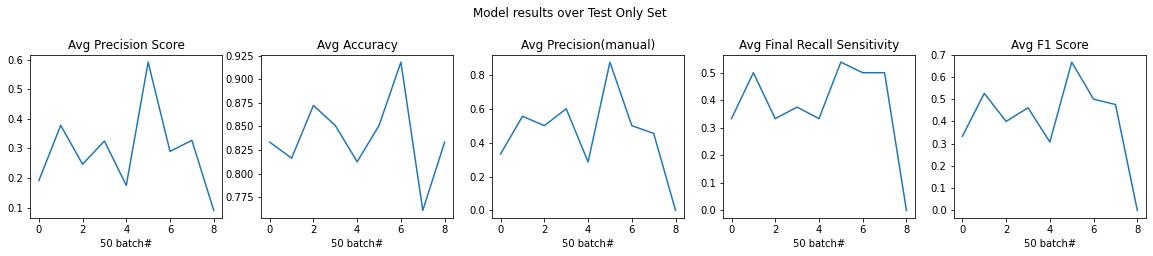

In [ ]:
#
# GENERATE TEST METRICS FOR DEBUGGING
#

if (run_test == 1):
    test_p_file = os.path.join(tensorboard_dir,'test_metrics_052521.pickle')
    tdata = pickle.load( open( test_p_file, "rb" ) )
    print(len(tdata))
    print(len(total_final_recall_sens))
    total_accuracy = tdata[5]
    print('Avg precision score (sklearn) = ',sum(total_average_precision)/len(total_average_precision))
    print('Avg Final accuracy (TP+TN)/(TP+FP+FN+TN)  = ',sum(total_final_accuracy)/len(total_final_accuracy))
    print('Avg Final precision TP/(TP+FP) = ',sum(total_final_precision)/len(total_final_precision))
    print('Avg Final recall TP/(TP+FN) = ',sum(total_final_recall_sens)/len(total_final_recall_sens))
    print('Avg F1 score 2(recall *precision)/(recall+precision)= ',sum(total_f1_score)/len(total_f1_score))
    print('Avg Correct prediction&truth matching = ',sum(total_accuracy)/len(total_accuracy))
    
    fig, axs = plt.subplots(1,5,figsize = (20, 3))
    fig.suptitle('Model results over Test Only Set', y=1.1)
    axs[0].plot(total_average_precision)
    axs[0].title.set_text('Avg Precision Score')
    axs[0].set_xlabel('50 batch#')

    axs[1].plot(total_final_accuracy)
    axs[1].title.set_text('Avg Accuracy')
    axs[1].set_xlabel('50 batch#')

    axs[2].plot(total_final_precision)
    axs[2].title.set_text('Avg Precision(manual)')
    axs[2].set_xlabel('50 batch#')

    axs[3].plot(total_final_recall_sens)
    axs[3].title.set_text('Avg Final Recall Sensitivity')
    axs[3].set_xlabel('50 batch#')

    axs[4].plot(total_f1_score)
    axs[4].title.set_text('Avg F1 Score')
    axs[4].set_xlabel('50 batch#')


    b_files=0
    c_files = 0
    n_files = 0
    
    for ii in test_files: #full_file_list[test_]:
        if ('Benign' in ii):
            b_files +=1
        elif ('Cancer' in ii):
            c_files += 1
        else:
            n_files +=1
    print('Benign files, Cancer files,Normal files,Total files = ',b_files, c_files,n_files,b_files+c_files+n_files)
#fig.suptitle('DBT-P01110 LCC CANCER slice34')


#
# Confusion Matrix
#

#scores = [TP, FP,TN,FN]
print(total_TP, total_FP,total_TN,total_FN)
#TP FN
#FP TN
print('       PREDICTED')
print('ACTUAL [' + str(sum(total_TP)) + '    ' + str(sum(total_FN)) + ']')
print('       [' + str(sum(total_FP)) + '    ' +str(sum(total_TN)) + ']')
    #total_average_precision,total_final_accuracy, 
    #             total_final_precision, total_final_recall_sens, 
    #             total_f1_score, total_accuracy
#        print('Predicted Matches #0,#1,#2 = ',num0,num1,num2)
#    print('BN Match = ',BN,BP)
#    final_accuracy = (TP+TN)/(TP+FP+FN+TN +1e-12)
#    print('Accuracy is ',final_accuracy)
#    final_precision = TP/(TP+FP + 1e-12)
#    print('Precision is ',final_precision)
#    final_recall_sens = TP/(TP + FN + 1e-12)
#    print('Recall/Sens = ',final_recall_sens)
#    f1_score = 2 *(final_recall_sens * final_precision)/(final_recall_sens + final_precision +1e-12)
#    print('F1 score = ',f1_score)

In [ ]:
### TRAIN THE NETWORK



start_epoch = 0 #used for reloading model
stop_epoch = 300
training_loss = {}
validation_loss = {}
training_accuracy = {}
validation_accuracy ={}
tloss = []
vloss = []

best_accuracy = 0.0 #store highest accuracy for current model
best_validation_loss = 0.0 #store highest validation loss over epochs
best_validation_precision = 0.0 #store highest validation precision over epochs

training_average_precision ={}
training_final_accuracy ={}
training_final_precision = {}
training_final_recall_sens = {}
training_f1_score = {}


validation_average_precision = {}
validation_final_accuracy = {}
validation_final_precision = {}
validation_final_recall_sens = {}
validation_f1_score = {}

##################################################################
############# RESUME FROM EARLIER CHECKPOINT
###################################################################
resume_checkpoint = 0
if (resume_checkpoint == 1):
    #Mixing GPU and CPU model saves doesn't seem to map well yet
    check_file = os.path.join(model_dir,'model_final_1')
    checkpoint = torch.load(check_file, map_location=torch.device('cpu'))
    model_vgg16.load_state_dict(checkpoint)
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    

for epoch in range(start_epoch,stop_epoch): #(2):  # loop over the dataset multiple times

    training_loss[epoch] = []
    validation_loss[epoch] = []
    training_accuracy[epoch] = []
    validation_accuracy[epoch]= []
  



    #Advanced metrics based upon True/False values
    training_average_precision[epoch] = []
    training_final_accuracy[epoch] =[]
    training_final_precision[epoch] = []
    training_final_recall_sens[epoch] = []
    training_f1_score[epoch] = []


    validation_average_precision[epoch] = []
    validation_final_accuracy[epoch] = []
    validation_final_precision[epoch] = []
    validation_final_recall_sens[epoch] = []
    validation_f1_score[epoch]= []


#
# TRAINING SECTION
#
    model_vgg16.train()     # Optional when not using Model Specific layer
    running_loss = 0.0
    iteration_counter = 0 #keep track of total runs
    #for i, data in enumerate(dataloader, 0):  #works for general setup!!
    for i, data in enumerate(dataloader_training, 0):
        model_vgg16.train() #reset if validation step kicked off
        iteration_counter = iteration_counter + 1
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs = data['image'].type(FloatTensor)
        labels = data['label'] #.type(FloatTensor)

        if (train_on_gpu):
            inputs, labels = inputs.to(dev), labels.to(dev)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_vgg16(inputs) #.permute(0, 1, 2, 3))
        if (i == 0):
            #show the initial sizes as a check
            print(outputs.size())
            print(labels.size())

        ### L1 loss complains about outputs columns being out of order, permute
        ### outputs to match up
        use_L1 = 0
        if (use_L1==1):
            outputs= outputs.permute(3,1,2,0)
            loss = L1loss(outputs,labels)
        else:
            #outputs = nn.Softmax2d(outputs)
            
            outputs=torch.flatten(outputs, start_dim=1)
            #weight_balance = torch.tensor([0,0])
            #loss = criterion(outputs, labels.long())
            loss = criterion(outputs, labels.long())
        training_loss[epoch].append(loss.item())
        print('Loss = ', loss.item())

        #
        # ACCURACY
        #
        if (i%1 == 0):
            #print(outputs)
            y_pred_softmax = torch.log_softmax(outputs, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            print(y_pred_tags)
            print(labels)
            correct_pred = (y_pred_tags == labels).float()
            accuracy = correct_pred.sum() / len(correct_pred)
            #accuracy = torch.round(accuracy)
            training_accuracy[epoch].append(accuracy)
            print('-----#correct, training accuracy = ',correct_pred,accuracy)


            #advanced metrics
            average_precision_training, final_accuracy_training, \
            final_precision_training, final_recall_sens_training, \
            final_f1_score, scores = calculate_metrics(labels,y_pred_tags)

            training_average_precision[epoch].append(average_precision_training)
            training_final_accuracy[epoch].append(final_accuracy_training)
            training_final_precision[epoch].append(final_precision_training)
            training_final_recall_sens[epoch].append(final_recall_sens_training)
            training_f1_score[epoch].append(final_f1_score)
            print('TRAIN METRICS: ',average_precision_training, final_accuracy_training, final_precision_training, final_recall_sens_training, final_f1_score)
        #
        # TENSOR BOARD ADD
        #
        if (use_tensor_board == 1):
            writer.add_scalar("Loss/train", loss, epoch)


        loss.backward()
        optimizer.step()

        # print statistics
        if (i %500 == 0):
            if(train_on_gpu == 1):
                !nvidia-smi
        if (i % 100 == 0):
            running_loss += loss.item()
            print('loop,epoch, loss, total running loss = ',i,epoch, loss.item(), running_loss/100)
            running_loss = 0.0


###############################################
# VALIDATION STEP
###############################################
    if (iteration_counter %1 == 0):
        model_vgg16.eval()     # Optional when not using Model Specific layer
        valid_loss = 0.0

        with torch.no_grad():
            for ii, vdata in enumerate(dataloader_validation, 0):
                # get the inputs; data is a list of [inputs, labels]
                #inputs, labels = data
                vinputs = vdata['image'].type(FloatTensor)
                vlabels = vdata['label'] #.type(FloatTensor)

                #assert(len(vlabels) == bsize), "Wrong number of val labels"

                if (train_on_gpu):
                    vinputs, vlabels = vinputs.to(dev), vlabels.to(dev)

                target = model_vgg16(vinputs)

                #flatten for cross entropy loss
                target=torch.flatten(target, start_dim=1)
                loss = criterion(target,vlabels)
                valid_loss = loss.item()# * data.size(0)
                validation_loss[epoch].append(valid_loss)


                y_val_softmax = torch.log_softmax(target, dim = 1)
                _, y_val_tags = torch.max(y_val_softmax, dim = 1)
                print('val prediction:',y_val_tags)
                print('val truth lbls:',vlabels)
                correct_pred = (y_val_tags == vlabels).float()
                val_accuracy = correct_pred.sum() / len(correct_pred)
                validation_accuracy[epoch].append(val_accuracy.item())
                print('VALIDATION #correct, validation accuracy = ',correct_pred,val_accuracy)

                #advanced metrics
                average_precision_validation, final_accuracy_validation, final_precision_validation, final_recall_sens_validation, final_f1_score_validation, val_t_scores = calculate_metrics(vlabels,y_val_tags)

                validation_average_precision[epoch].append(average_precision_validation)
                validation_final_accuracy[epoch].append(final_accuracy_validation)
                validation_final_precision[epoch].append(final_precision_validation)
                validation_final_recall_sens[epoch].append(final_recall_sens_validation)
                validation_f1_score[epoch].append(final_f1_score_validation)
                print('VALIDATION METRICS: ',average_precision_validation, final_accuracy_validation, 
                      final_precision_validation, final_recall_sens_validation, final_f1_score_validation)

                ################################################################
                #SELECT MODEL TO SAVE 
                ################################################################
                #if (  ((val_accuracy > best_accuracy) or (val_accuracy > 0.9)) and 
                if (  ((final_accuracy_validation > best_accuracy) or (final_accuracy_validation > 0.8)) and 
                    ((valid_loss <= 0.3) and (valid_loss >= 0.000001)) and 
                    ((average_precision_validation >= 0.70) or (average_precision_validation > best_validation_precision) )):
                    print('!!!!!Accuracy < previous. Saving model. acc= ',val_accuracy)
                    #store highest values, later iterations must beat these
                    best_accuracy = final_accuracy_validation #val_accuracy
                    best_validation_loss = valid_loss
                    best_validation_precision = average_precision_validation
                    #save this model off
                    best_model_name = 'vgg16_best_accuracy_' + str(np.int(best_accuracy*100)) + '_EPOCH_' +str(epoch)+'_' + str(valid_loss)
                    torch.save(model_vgg16.state_dict(),os.path.join(model_dir,best_model_name))





####################################################
# SAVE INTERMEDIATE FILES
####################################################

    training_pickle = os.path.join(tensorboard_dir,'tensor_training_loss.pickle')
    validation_pickle = os.path.join(tensorboard_dir,'tensor_validation_loss.pickle')
    accuracy_pickle = os.path.join(tensorboard_dir,'tensor_training_accuracy.pickle')
    val_accuracy_pickle = os.path.join(tensorboard_dir,'tensor_validation_accuracy.pickle')
    training_metrics_pickle = os.path.join(tensorboard_dir,'training_tp_metrics.pickle')
    validation_metrics_pickle = os.path.join(tensorboard_dir,'validation_tp_metrics.pickle')


    pickle.dump(training_loss, open( training_pickle, "wb" ),protocol=5 )
    pickle.dump(validation_loss, open( validation_pickle, "wb" ),protocol=5 )
    pickle.dump(training_accuracy,open( accuracy_pickle, "wb" ),protocol=5 )
    pickle.dump(val_accuracy, open(val_accuracy_pickle,"wb"), protocol=5)



    pickle.dump([training_average_precision, training_final_accuracy, training_final_precision, training_final_recall_sens, training_f1_score],  open(training_metrics_pickle, "wb"), protocol = 5)
    pickle.dump([validation_average_precision, validation_final_accuracy, validation_final_precision, validation_final_recall_sens, validation_f1_score],  open(validation_metrics_pickle, "wb"), protocol = 5)

    #save a midterm file
    if (epoch %5 == 0):

        save_model_mid = 'model_final_' + str(epoch) + '_' + str(np.int(best_accuracy*100))
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_vgg16.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, os.path.join(model_dir,save_model_mid))

    if (use_tensor_board == 1):
        writer.flush() #write out all the info to the board

torch.save(model_vgg16.state_dict(),os.path.join(model_dir,'vgg16_trained_final'))
print('Finished Training')
if (use_tensor_board == 1):
    writer.close()

torch.Size([50, 3])
torch.Size([50])
Loss =  1.099058985710144
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2], device='cuda:0')
tensor([1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 0, 2, 0, 1, 2, 2, 1, 1, 0, 0,
        1, 1], device='cuda:0')
-----#correct, training accuracy =  tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0') tensor(0.1600, device='cuda:0')
Predicted Matches #0,#1,#2 =  0 0 50
BN Match =  0 0
Accuracy is  0.15999999999999678
Precision is  0.15999999999999678
Recall/Sens =  0.999999999999875
F1 score =  0.2758620689652698
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
!ls '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER/'

DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx0_cy1318_244_244_FLIPH.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx0_cy1318_244_244.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx0_cy1318_244_244_ROT180.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx0_cy1318_244_244_ROT270.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx0_cy1318_244_244_ROT90.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx218_cy1319_244_244_FLIPH.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx218_cy1319_244_244.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx218_cy1319_244_244_ROT180.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx218_cy1319_244_244_ROT270.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx218_cy1319_244_244_ROT90.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx224_cy1147_244_244_FLIPH.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx224_cy1147_244_244.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx224_cy1147_244_244_ROT180.pickle
DBT-P00107_DBT-S05365_lcc_Cancer_s34_cx224_cy1147_244_244_ROT270.pickle
DBT-P00107_DBT-S05365_lcc_Ca

Text(0.5, 1.0, 'Validation Loss')

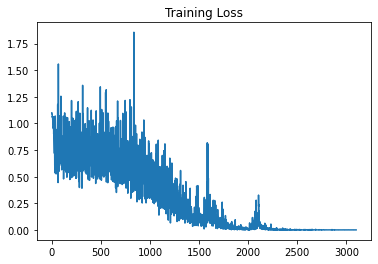

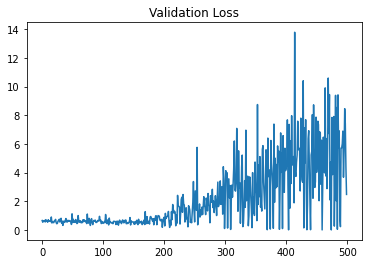

In [ ]:
#### Test out saved pickle files
#tdata = training_pickle


training_pickle = os.path.join(tensorboard_dir,'tensor_training_loss.pickle')
validation_pickle = os.path.join(tensorboard_dir,'tensor_validation_loss.pickle')
accuracy_pickle = os.path.join(tensorboard_dir,'tensor_training_accuracy.pickle')
val_accuracy_pickle = os.path.join(tensorboard_dir,'tensor_validation_accuracy.pickle')
training_metrics_pickle = os.path.join(tensorboard_dir,'training_tp_metrics.pickle')
validation_metrics_pickle = os.path.join(tensorboard_dir,'validation_tp_metrics.pickle')



tdata = pickle.load( open( training_pickle, "rb" ) )
vdata =  pickle.load(open(validation_pickle,"rb"))
#adata =  pickle.load(open(accuracy_pickle,"rb"))
#val_acc = pickle.load(open( val_accuracy_pickle, "rb" ))
training_metrics =  pickle.load(open(training_metrics_pickle,"rb"))
val_metrics = pickle.load(open(validation_metrics_pickle,"rb"))
#torch.load(accuracy_pickle,map_location=torch.device('cpu'))

tdata.keys()

total_losses= []
epoint = []
counter = 0
for ii in tdata.keys():
    for num in tdata[ii]:
        total_losses.append(num)
        counter+=1
    epoint.append(counter)

plt.figure()
plt.plot(total_losses)
plt.title('Training Loss')

ax = plt.gca()
#ax.set_xticks(epoint[0::10])
#ax.xaxis.set_major_locator([1.1, 1.9, 2.5])

total_validation = []
for ii in vdata.keys():
    for num in vdata[ii]:
        total_validation.append(num)

plt.figure()
plt.plot(total_validation)
plt.title('Validation Loss')


#total_accuracy = []
#for ii in adata.keys():
#    for num in adata[ii]:
#        total_accuracy.append(num)


#plt.figure()
#plt.plot(total_accuracy)
#plt.title('Total Acc')




In [ ]:
#
#Disconnect from the VM to save our GPU time
#
!kill -9 -1

In [ ]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
model_children = list(model_vgg16.children())
print(len(model_children))
print(model_children[1])


# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children[1])):
    if type(model_children[1][i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[1][i].weight)
        conv_layers.append(model_children[1][i])
    elif type(model_children[1][i]) == nn.Sequential:
        for j in range(len(model_children[1][i])):
            for child in model_children[1][i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")
print(len(model_weights))
print(np.shape(model_weights[0]))

# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")




# visualize the first conv layer filters
print(np.shape(model_weights[3]))
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

In [ ]:
check_file = os.path.join(model_dir,'model_final_15')
checkpoint = torch.load(check_file)#, map_location=torch.device('cpu'))
#model_vgg16.load_state_dict(checkpoint)
#best_acc = checkpoint['acc']
#start_epoch = checkpoint['epoch']
model_vgg16.eval()

In [ ]:
outputs #.softmax(dim=1)
loss
y_pred_softmax = torch.log_softmax(outputs, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
print(y_pred_tags)
print(labels)
correct_pred = (y_pred_tags == labels).float()
acc = correct_pred.sum() / len(correct_pred)

acc = torch.round(acc * 100)
print('correct_pred, accuracy = ',correct_pred,acc)
#torch.flatten(outputs, start_dim=1)

In [ ]:
#target.topk
#target = model_vgg16(vinputs)
target = outputs
print(inputs.shape)
#vout = model_vgg16(inputs)
print(vout.shape)
vout_save = vout

#probabilities = torch.exp(vout).data

# getting the topk (=5) probabilites and indexes
# 0 -> probabilities
# 1 -> index
print('vout size = ', vout.shape)
#probs = torch.log_softmax(target, dim=1)
#probs = torch.softmax(vout.flatten, dim=1)
probs = torch.flatten(vout,3)
#print('prob shape = ',probs.shape)
print(torch.softmax(probs,dim=0))
#prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
#index = torch.topk(probabilities, topk)[1].tolist()[0] # index
print(probs[0,:].sum()/len(probs))

In [ ]:
import torch.nn.functional as nnf

# ...
prob = nnf.softmax(outputs, dim=1)

top_p, top_class = prob.topk(1, dim = 1)
print(top_p,top_class)

In [ ]:
counter = 0
for ii in dataloader_validation:
    print(ii)
    counter= counter + 1
    if (counter > 0):
        break

In [ ]:
#outputs=torch.flatten(outputs, start_dim=1)
#loss = criterion(outputs, labels.long())

outputs = model_vgg16(inputs) #.permute(0, 1, 2, 3))
print(outputs.size())
print(labels.size())
a= torch.flatten(outputs,start_dim=1)

print(outputs.mean())
print(a)
criterion(a,labels)

In [ ]:
#model_vgg16.state_dict()
print(outputs.shape)
a=outputs.view(4*512*7,4)
print(a.shape)
print(labels)
x=torch.flatten(outputs, start_dim=1)

#proper_target = torch.argmax(labels, dim=1)  # make sure keepdim=False
#loss = criterion(outputs, proper_target)


In [ ]:
torch.tensor([2])
a=outputs/2
a = torch.tensor(a)
m = np.mean(inputs)
b= inputs/1000
b

In [ ]:
num_correct = 0
total = 0
model_vgg16.eval()

with torch.no_grad():
    for i, data in enumerate(dataloader_test, 0):
    #for data, labels in test_subset:
        #data = data.to(device=device)
        #labels = labels.to(device=device)
        inputs = data['image'].type(FloatTensor)
        labels = data['label'] #.type(FloatTensor)

        predictions = model_vgg16(inputs) #for testing, only pass in images, no labels
        predictions = predictions.permute(3,1,2,0)
        num_correct += (predictions == labels).sum()
        total += labels.size(0)

    print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

In [ ]:
#
# Test out every file for the correct shape
#
total_files = len(full_file_list)
for counter, file_name in enumerate(full_file_list):

    text_tokens = file_name.split(sep='_')
    label_class = text_tokens[3] #get the label token in 4th position
    category_name =  label_class.upper() 

    #print('testing file = ', counter, file_name)
    cfile = os.path.join(patch_dir,category_name,file_name)
    image = pickle.load( open( cfile, "rb" ) )
    #print('testing ',cfile)
    shape = np.shape(image)
    if ((shape[0] != 3) or (shape[1] != 244) or (shape[2] != 244)):
        print('Failed file ',file_name, shape)

#    else:
#        print('testing file = ', counter, file_name, shape)



In [ ]:
#patch_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 
!ls /content/gdrive/MyDrive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL

In [ ]:

cfile = os.path.join(patch_dir,'NORMAL','DBT-P03406_DBT-S05192_lcc_Normal_s83_cx520_cy1165_244_244.pickle')
image = pickle.load( open( cfile, "rb" ) )
image.shape
